# Chapter 2: Charlie wants a loan


### Quick Start

If you are in the colab environment, please follow the steps below:

Step 1: Click Runtime -> Run all to run the notebook.

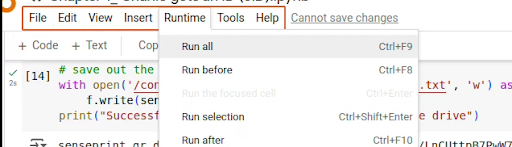

Step 2: You will be prompted to give permission to access your Google Drive files, which is essential for the notebook to save intermediate results. Please click on "Connect to Google Drive".

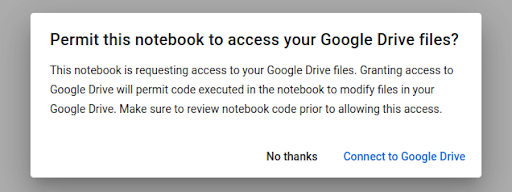

Step 3: Please click on "Run anyway" to run the notebook!

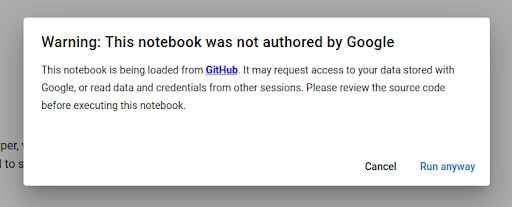

As an alternative to run all cells, you can also run cell by cell and give aforementioned permissions when prompted!

### 2.1 Overview
1. [Chapter 1_ Charlie gets an ID (eID)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%201_%20Charlie%20gets%20an%20ID%20(eID).ipynb)
1. [Chapter 2_ Charlie wants a loan (eID)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%202_%20Charlie%20wants%20a%20loan%20(eID).ipynb)
1. [Chapter 3_ Charlie signs up for Petflix (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%203_%20Charlie%20signs%20up%20for%20Petflix%20(FacePKI).ipynb)
1. [Chapter 4_Charlie_signs into Petflix (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%204_Charlie_signs%20into%20Petflix%20(FacePKI).ipynb)
1. [Chapter 5_Petflix sends Charlie a catbond meme (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%205_Petflix%20sends%20Charlie%20a%20catbond%20meme%20(FacePKI).ipynb)
1. [Chapter 6_Charlie decrypts catbond meme (FacePKI)](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%206_Charlie%20decrypts%20catbond%20meme%20(FacePKI).ipynb)

### 2.2 Introduction

Charlie Cryptofson had always dreamed of driving the latest sports car through the streets of Cryptoville. The sleek lines and roaring engine consumed his thoughts. There was just one obstacle: he didn’t have enough money to buy it. Determined to make his dream a reality, Charlie headed to Cryptoville Bank to apply for a loan. <br><br>

Upon entering the bank, Charlie was welcomed by a courteous bank officer. After discussing the loan requirements, the officer explained that the bank would need to verify Charlie's identity through his SensePrint. This advanced verification process would confirm that only Charlie could apply for the loan in his name.<br><br>

The bank officer then launched the Government mobile app, which is powered by the SenseCrypt mobile SDK, on their device. First, they scanned the QR code on Charlie’s eID card, initiating the identity verification process. However, confirming the identity wasn't the only step. In order to approve the loan, the bank also needed to verify Charlie’s age, credit score, criminal records and citizenship. The app prompted the officer to capture a facial scan of Charlie, ensuring that the person standing before them was indeed him. The metadata collected from these verification prints—age, credit score, and citizenship—was used by the bank to assess whether Charlie was eligible for the loan.<br><br>

**Flow of Events:**
1. Verifier (Bank) scans user (Charlie) QR code to obtain his SensePrint.
1. Verifier/Trusted Issuer (since scanning through the app) scans user face.
1. Verifier/Trusted Issuer (since verifying through the app) sends a request with user SensePrint and face to the Sensecrypt server to verify user identity and metadata.
1. Sensecrypt server returns if user is verified or not. If verified, the metadata is also returned.
1. Verifier can then access this metadata and trust the authenticity of user identity and metadata.

*Note: Custom apps can be built on top of the SenseCrypt mobile SDK to access the SenseCrypt server API endpoints. What is shown here are the raw API calls made through the SenseCrypt mobile SDK in order to aid your understanding of the overall process flow.*

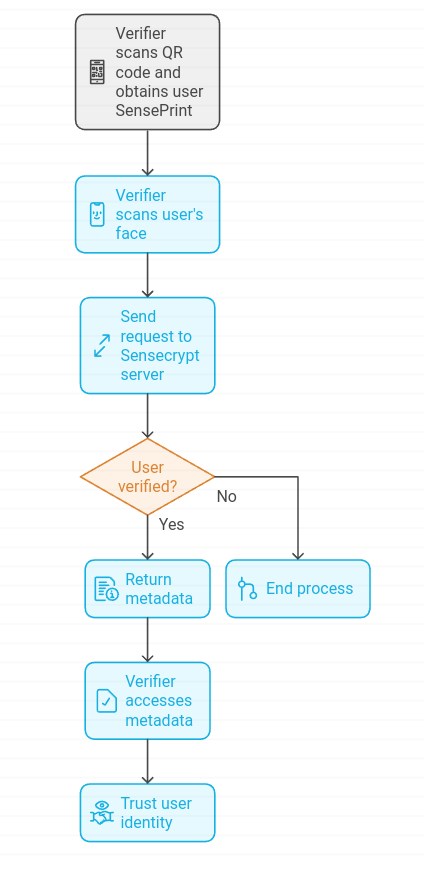

### 2.3 Pre-run cells

In [5]:
# **********************************INPUT************************************#
# Please provide the url of the SenseCrypt server and the associated api key.#
# ***************************************************************************#
url = "https://apiserver.sensecrypt.com/"
api_key = "BjeaACQczWh5Xw5sIEE0mBu1mpCnfOfmM47PT67f7mw="

In [6]:
# Run these helper functions, which will be used later in the notebook
from io import BytesIO
import base64
import requests
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

using_colab = True
try:
    # mount your private google drive for saving and loading out artifacts to be used in subsequent notebooks
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not in Google Colab. Assume running in the local environment and not accessing google drive storage.")
    using_colab = False


def call_sensecrypt_server(api_key, data, endpoint, url):

    full_url = url + endpoint

    # Prepare headers
    headers = {
        "x-api-key": api_key,
        "Content-Type": "application/json"
    }

    # Send POST request
    response = requests.post(full_url, json=data, headers=headers)

    # Check the response status and content
    if response.status_code == 200:
        print("Request was successful")
        return response  # Return JSON data if the request was successful
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)  # Print the raw response content
        return None

def convert_image_to_base64(image, format="JPEG"):

    # Save the image as a byte stream in memory
    buffered = BytesIO()
    image.save(buffered, format=format)  # Default format is 'JPEG', can be changed
    img_bytes = buffered.getvalue()

    # Convert byte stream to Base64
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')

    return img_base64

def fetch_image(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    return img

Not in Google Colab. Assume running in the local environment and not accessing google drive storage.


### 2.4 Using the `/verify-raw` API Endpoint [(Link to documentation)](https://docs.sensecrypt.com/sensecrypt-v3.1.1/sensecrypt-server/sensecrypt-eid/decrypting-a-raw-senseprint)


An example of the mobile app using the SenseCrypt `/verify-raw` API endpoint.

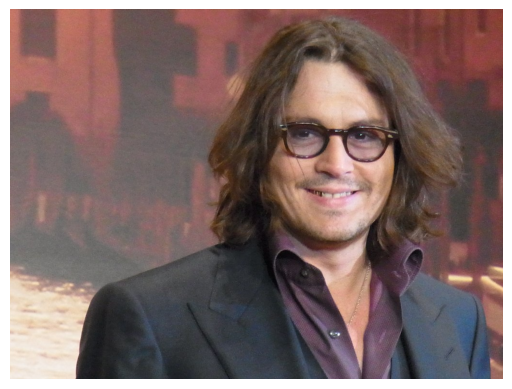

img_base64: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQ ...


In [7]:
# Preparing the inputs for the endpoint parameters

# prepare face_base_64 input
# Bank officer takes a photo of Charlie
# Here we will load the image from link to simulate the webcam image
import matplotlib.pyplot as plt

# Load the image from link
if using_colab:
    image = fetch_image("https://raw.githubusercontent.com/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/refs/heads/main/images/JohnnyDepp_2.jpg")
else:
    image = Image.open("./images/JohnnyDepp_2.jpg")
plt.imshow(image)
plt.axis("off")
plt.show()

# convert to base64
img_base64 = convert_image_to_base64(image)

print("img_base64:", img_base64[:50], "...")  # Print the first 50 characters of the base64 string


In [8]:
# prepare the senseprint_base_64 input
# load in the senseprint from predefined link for this example walkthrough
# in real world scenario, this would have been derived from the scan of the QR code
# see the chapter 1 for how to generate, scan the QR code and convert to senseprint_base_64
if using_colab:
    file_path = '/content/drive/My Drive/senseprint_qr_data.txt'
else:
    file_path = './temp/Chapter1/senseprint_qr_data.txt'
    assert os.path.exists(file_path), 'SensePrint QR data does not exist! Please generate the qr data by running the chapter 1 notebook :)'

# Open the file and read it as a string
with open(file_path, 'r') as file:
    senseprint_base_64 = file.read()
# Print the content of the file
print("senseprint_base_64:", senseprint_base_64)  # Print the first 50 characters

senseprint_base_64: ApiBrQakACi6TZNNwJhDjtmDkvjWSewfiTY72rs3IVI+8g3l6sDheWxfi+A8zxRkQD2OckLMMfobbRSEmtWO+VRIO21JPYB18NV/MfLgmrjZrfqihqj+tuwYwhtRGD4kZoygdtkOAtpJGouSQv87nqYZKOH3V8sJ/kDOl1fCVHZhYnisnKP10TPSFo6cfVGtw28167iAjdeO4+CutWwYeckLSNU+vQ7c95LKLgc/hyc71x1+zmcNQ/2Gy/0MTtLQrxKKk82H0AjcDGstbjW2vFl4NNTk/WAZXsBOn4rpRauKgwN06xoQ738QSEBvKTFBmTngYcUytAw/vRCmvvxqz6QDGIi3PCfjejlGOhsOgZBr2+/9YpLeqHSwiOCpIOJuA89bZTHBirLzR62kQtUAagz0H8795x3Qa8siLxMpPTVneHfeWCorTHmxA2kgE7UZ52Q76rw+0jAE56ZkptnE7mJxdf4+QvQm33R8BiQIZizQgcCc/q6aXEyHGKn6JWq8CAKd20HUjftigVXOMrf8AOUpQSB5UKzLOxYKX6lhbOZedQIMmhBp0P+GZuAq3392o5V8F1IFaLOz0c458z4HrbFfXN9n8h9twer7cOA6HoaNhMIyVCf+Hc/wlkThKK0NHKiFeR9YIXrm2L2AMEGXbZWsIdj5/BYOwnhjjjjEC9Tax32YqVYyQAwOZCOiCcHggkDCoy6UFZ/SXND03kUg2hmIoZjZOqE87e4Aktb2XT5KNmEZN613uvCM2iSl618D9NUH8Mlg


Request was successful
{'name': 'Charlie Cryptofson', 'address': '123 Crypt Street, Cryptoville', 'citizenship': 'Cryptonian', 'criminal_record': 'None', 'credit_score': '700', 'date_of_birth': '17-09-1983', 'age': '38'}


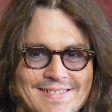

In [9]:
# call the API

data = {

    "senseprint_base_64": senseprint_base_64,
    "face_base_64": img_base64
}

endpoint = "/verify-raw"

response = call_sensecrypt_server(api_key, data, endpoint, url)

# Now that the request was successful, Charlie has been verified.
# If the request is not successful, the api would return a verification failed error msg

# access the metadata
metadata = response.json()['metadata']
print(metadata)

# show the face_crop_base_64 for visual confirmation
image_data = base64.b64decode(response.json()["face_crop_base_64"])
image = Image.open(BytesIO(image_data))

image

With the facial scan complete, the Government mobile app swiftly confirmed Charlie’s identity. A small green checkmark appeared on the bank officer’s screen, signaling that the verification was successful. <br><br>

The officer then accessed the metadata linked to Charlie, which was issued by the Government (the trusted Issuer). He looked in the `metadata["age"]`,and now knows that Charlie is indeed 38 years old! This metadata also includes other key details like Charlie’s credit score, criminal record, and citizenship status. Confident in the authenticity of this data, the officer reviewed it carefully. Since Charlie fell within the working age range, had a strong credit rating, no criminal record, and was a verified citizen of Cryptoville, he met all the necessary criteria for the loan.<br><br>

“Congratulations, Mr. Cryptofson,” the officer said with a warm smile. “Your identity has been verified, your details have been reviewed, and your loan is approved.”<br><br>

With the loan now secured and the keys in hand, Charlie’s dream finally became a reality. He slid into the driver’s seat of his sleek new sports car, the engine purring as he drove through the streets of Cryptoville. Thanks to SenseCrypt’s seamless verification process, both his identity and loan were confirmed without a hitch. As the city lights flashed by, Charlie smiled—his dream of driving the latest sports car had come true, and with his identity safely secured, the future felt limitless.


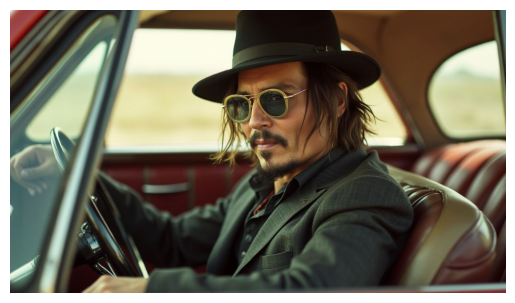

Charlie's New Car!


In [10]:
if using_colab:
    image = fetch_image("https://raw.githubusercontent.com/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/refs/heads/main/images/johnny_in_car.jpg")
else:
    image = Image.open("./images/johnny_in_car.jpg")
plt.imshow(image)
plt.axis("off")
plt.show()
print("Charlie's New Car!")

Continue on to Chapter 3: Charlie signs up for Petflix (FacePKI) [here](https://colab.research.google.com/github/Seventh-Sense-Artificial-Intelligence/SenseCrypt-Walkthrough/blob/main/Chapter%203_%20Charlie%20signs%20up%20for%20Petflix%20(FacePKI).ipynb)!